### Figure 2 : Ripple oscillations

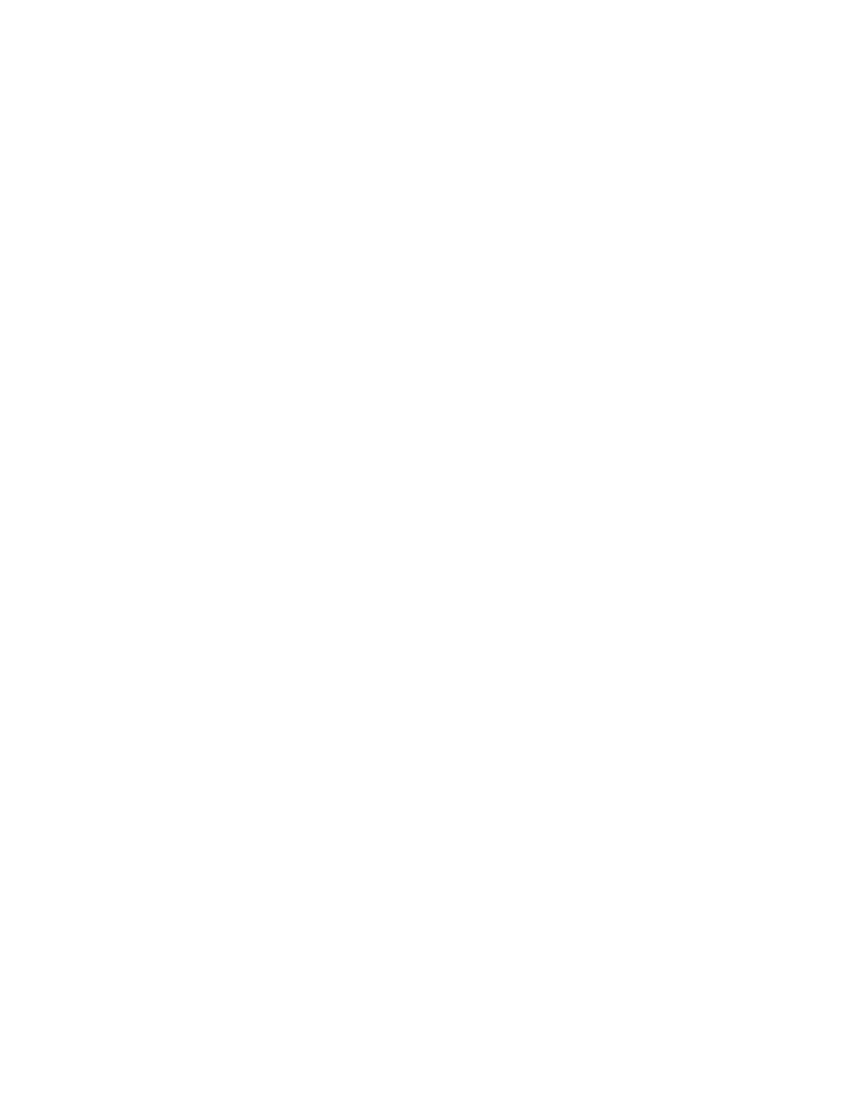

In [66]:
import matplotlib.pyplot as plt
import numpy as np
import subjects
from subjects import lineplot_kw, errorbar_kw,boxplot_kw
import pandas as pd
import seaborn as sns
from neuropy.plotting import Fig
from scipy import stats
from neuropy.plotting.dataviz import boxplot,barplot
from statannotations.Annotator import Annotator


grpdata = subjects.GroupData()
group = ['NSD','SD']

# ripple
psd = grpdata.ripple_psd
examples = grpdata.ripple_examples
power= grpdata.ripple_zscore

ripple_autocorr = grpdata.ripple_autocorr
ripple_autocorr = ripple_autocorr[ripple_autocorr.lag_time>=-1]

rate = grpdata.ripple_rate
colors_ripple_rate = subjects.colors_sd(1.3)

total_dur = grpdata.ripple_total_duration
colors_rpl_dur = subjects.colors_sd(1.2)

peak_freq = grpdata.ripple_peak_frequency
peak_freq = peak_freq[(peak_freq['t']!='pre')&(peak_freq["t"]!="maze")]
colors_pf = subjects.colors_sd(1.3)

# pbe

pbe_rate = grpdata.pbe_rate
pbe_total_dur = grpdata.pbe_total_duration

# frate
frate_in_rpl = grpdata.frate_in_ripple
colors_frate = [
    [subjects.nsd.color(0.9), subjects.nsd.color(1.9)],
    [subjects.sd.color(1), subjects.sd.color(1.5)],
]

plt.clf()
fig = Fig(grid=(7, 7), fontsize=7)
filename = subjects.figpath_sd / "figure2"
caption = "Ripple and PBEs compared between SD and NSD sessions.\n(A) Mean ripple power spectral density across SD and NSD sessions during Pre, Maze and POST. Error bars indicate +/- SEM.\n(B) Distribution of peak ripple frequency calculated using wavelet compared across SD (orange) and NSD (purple) at selected epochs of each session. \n(C) Rate of ripple occurence during POST of SD (top left) and NSD (top right) sessions. Black dashed line represent median across sessions. Bottom panel shows integrated ripple duration during POST. \n(D) Same as (C) but of PBE events. \nE) Normalized z-scored firing rate within ripples calculated at various epochs for pyramidal and interneurons. Error bars indicate 90% CI."


### Peak frequency and power

In [67]:
gs_ = fig.subplot2grid(fig.gs[1, :4], (1, 5))


for g, grp in enumerate(["NSD", "SD"]):
    ax = plt.subplot(gs_[0, g])
    df = peak_freq[peak_freq.grp == grp]
    sns.boxplot(
        data=df,
        x="t",
        y="f",
        width=0.5,
        ax=ax,
        **boxplot_kw(subjects.colors_sd(1)[g]),
    )
    ax.set_ylim([40, 300])
    ax.tick_params("x", labelrotation=30)
    # ax.set_xticklabels(ha='right')
    # ax.axis["bottom"].major_ticks.set_ha("right")

    ax.legend([], frameon=False)
    ax.set_ylabel("")
    if g == 0:
        ax.set_ylabel("Intraripple frequency (Hz)")
    ax.set_xlabel("Zt time (h)")


### Ripple autocorr
ax = fig.subplot(gs_[2])
sns.lineplot(
    data=ripple_autocorr,
    x="lag_time",
    y="auto_corr",
    hue="grp",
    ci=None,
    palette=subjects.colors_sd(1.4),
    lw=1,
)
ax.legend("", frameon=False)
ax.axis("off")


### Ripple zscore
for g, grp in enumerate(["NSD", "SD"]):
    ax = plt.subplot(gs_[0, g + 3])
    df = power[power.grp == grp]
    sns.boxplot(
        data=df,
        x="t",
        y="zscore",
        width=0.5,
        ax=ax,
        **boxplot_kw(subjects.colors_sd(1)[g]),
    )
    # ax.set_ylim([40, 300])
    ax.tick_params("x", labelrotation=30)
    # ax.set_xticklabels(ha='right')
    # ax.axis["bottom"].major_ticks.set_ha("right")

    ax.legend([], frameon=False)
    ax.set_ylabel("")
    if g == 0:
        ax.set_ylabel("Ripple power (zscore)")
    ax.set_xlabel("Zt time (h)")


orders = power.t.unique()
pairs = [((_, "NSD"), (_, "SD")) for _ in orders]
# pairs = [
#     (("0.0-2.5", "NSD"), ("0.0-2.5", "SD")),
#     (("2.5-5.0", "NSD"), ("2.5-5.0", "SD")),
#     (("5.0-7.5", "NSD"), ("5.0-7.5", "SD")),
# ]

annotator = Annotator(
    ax,
    pairs,
    data=power,
    x="t",
    y="zscore",
    order=orders,
    hue="grp",
    hue_order=group,
)
annotator.configure(test="t-test_ind", text_format="star", loc="outside", verbose=True)

# annotator.apply_and_annotate()


### Ripple rate

In [68]:
for g, grp in enumerate(group):
    ax = plt.subplot(fig.gs[2, g])
    # df = total_dur[total_dur.grp == grp]
    df = rate[rate.grp == grp]
    sns.lineplot(
        data=df,
        x="Zt",
        y="rate",
        marker='o',
        hue='sub',
        palette=[colors_pf[g]]*8,
        # ci=99,
        # showfliers=False,
        # width=0.5,
        ax=ax,
        # **lineplot_kw,
        markerfacecolor='w',
        markeredgecolor=colors_pf[g],
        color=colors_pf[g],
    )
    ax.set_ylim([0.2,1.2])
    ax.set_xlim(-0.5,2.5)
    ax.set_xlabel("Zt time (h)")
    ax.set_ylabel("")
    ax.tick_params('x',labelrotation=30)
    if g == 0:
        ax.set_ylabel("Ripple zscores")
        ax.set_ylabel("Ripple rate (Hz)")
    ax.legend('',frameon=False)

    orders = df.Zt.unique()
    pairs = [(orders[t1], orders[t2]) for t1,t2 in zip([0,1,2],[1,2,0])]

    annotator = Annotator(
        ax,
        pairs,
        data=df,
        x="Zt",
        y="rate",
        order=orders,
        # hue="grp",
        # hue_order=group,
    )
    annotator.configure(
        test="t-test_paired", text_format="star", loc="inside", verbose=True
    )

    annotator.apply_and_annotate()


# sns.barplot(data=total_dur,x='Zt',y='rpl_duration',hue='grp',ax=ax)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0-2.5 vs. 2.5-5.0: t-test paired samples, P_val:1.857e-03 t=4.850e+00
2.5-5.0 vs. 5.0-7.5: t-test paired samples, P_val:1.169e-01 t=1.788e+00
0.0-2.5 vs. 5.0-7.5: t-test paired samples, P_val:2.224e-06 t=1.402e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0-2.5 vs. 2.5-5.0: t-test paired samples, P_val:7.257e-01 t=-3.652e-01
2.5-5.0 vs. 5.0-7.5: t-test paired samples, P_val:1.966e-02 t=3.010e+00
0.0-2.5 vs. 5.0-7.5: t-test paired samples, P_val:1.954e-01 t=1.432e+00


### Pbe rate

In [69]:
for g, grp in enumerate(group):
    ax = plt.subplot(fig.gs[2, g+2])
    # df = total_dur[total_dur.grp == grp]
    df = pbe_rate[pbe_rate.grp == grp]
    n_sub = len(df['sub'].unique())
    sns.lineplot(
        data=df,
        x="Zt",
        y="rate",
        marker='o',
        hue='sub',
        palette=[colors_pf[g]]*n_sub,
        # ci=99,
        # showfliers=False,
        # width=0.5,
        ax=ax,
        # **lineplot_kw,
        markerfacecolor='w',
        markeredgecolor=colors_pf[g],
        color=colors_pf[g],
    )
    ax.set_ylim([0,0.7])
    ax.set_xlim(-0.5,2.5)
    ax.set_xlabel("Zt time (h)")
    ax.set_ylabel("")
    ax.tick_params('x',labelrotation=30)
    if g == 0:
        ax.set_ylabel("Ripple zscores")
        ax.set_ylabel("PBE rate (Hz)")
    ax.legend('',frameon=False)

    orders = df.Zt.unique()
    pairs = [(orders[t1], orders[t2]) for t1,t2 in zip([0,1,2],[1,2,0])]

    annotator = Annotator(
        ax,
        pairs,
        data=df,
        x="Zt",
        y="rate",
        order=orders,
        # hue="grp",
        # hue_order=group,
    )
    annotator.configure(
        test="t-test_paired", text_format="star", loc="inside", verbose=True
    )

    annotator.apply_and_annotate()


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0-2.5 vs. 2.5-5.0: t-test paired samples, P_val:2.454e-02 t=2.983e+00
2.5-5.0 vs. 5.0-7.5: t-test paired samples, P_val:3.767e-02 t=2.657e+00
0.0-2.5 vs. 5.0-7.5: t-test paired samples, P_val:9.970e-03 t=3.710e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0-2.5 vs. 2.5-5.0: t-test paired samples, P_val:1.492e-01 t=-1.620e+00
2.5-5.0 vs. 5.0-7.5: t-test paired samples, P_val:2.752e-03 t=4.514e+00
0.0-2.5 vs. 5.0-7.5: t-test paired samples, P_val:6.790e-02 t=2.157e+00


In [70]:
x = pbe_total_dur[(pbe_total_dur['grp']=='SD')&(pbe_total_dur['Zt']=='0.0-2.5')].pbe_duration
y = pbe_total_dur[(pbe_total_dur['grp']=='SD')&(pbe_total_dur['Zt']=='2.5-5.0')].pbe_duration

stats.wilcoxon(x,y,alternative='greater')

# Make separate boxes for SD and NSD sessions and talk about the trend i.e, increase from early late or decrease from early to late 

WilcoxonResult(statistic=6.0, pvalue=0.921875)

### Firing within ripples

In [71]:
k=0
for i,w in enumerate( ["inside", "outside"]):
    df_w = frate_in_rpl[frate_in_rpl["where"] == w]

    for i1, n in enumerate(["inter", "pyr"]):
        df = df_w[df_w["neuron_type"] == n]
        

        mean = df.groupby("time").mean()
        sem = df.groupby("time").sem(0).frate
        ax = plt.subplot(fig.gs[3,  k])
        # ax.bar(mean.index,mean.frate,color)

        barplot(data=df,x='grp',y='frate',hue='time',x_palette=colors_pf,ax=ax)
        # ax.errorbar(
        #     list(mean.index.values),
        #     mean.frate.values,
        #     sem,
        #     marker="o",
        #     color=frate_colors[i],
        #     capsize=2,
        #     markeredgecolor="w",
        #     # alpha=0.6,
        # )
        # ax.bar(
        #     mean_ev.index + val[i],
        #     mean_ev.ev,
        #     ec=ev_colors[i],
        #     color="w",
        #     yerr=np.vstack([np.zeros(len(sem_ev)),sem_ev]),
        #     # alpha=0.4,
        #     capsize=1.8,
        #     width=0.35,
        #     # ec='#7e7c7c',
        #     # ecolor="#545454",
        #     ecolor=ev_colors[i],
        #     # linewidth=2,
        #     error_kw=dict(elinewidth=0.7),
        # )

        k = k+1

        ax.set_ylabel('')


        # if row == 2:
        #     ax.set_ylim([-0.7, 1.0])
        # else:
        #     ax.set_ylim([-1, 1.5])
        ax.legend('',frameon=False)
        # ax.tick_params("x", labelrotation=30)
        # fig.legend(ax, ["PN", "IN"], colors_frate[i])

        if i == 0:
            ax.set_ylabel(f"Firing rate (z-scored)\n{w} ripples")
            fig.panel_label(ax, "C")


### saving

/home/bapung/Documents/Codes/NeuroPy/neuropy/plotting/figure.py:156: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(num=num, figsize=(8.5, 11), clear=True)
/home/bapung/Documents/Codes/NeuroPy/neuropy/plotting/figure.py:238: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig(filename, dpi=dpi)
/home/bapung/miniconda3/envs/data_analysis/lib/python3.10/site-packages/ipympl/backend_nbagg.py:336: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  self.figure.savefig(buf, format='png', dpi='figure')


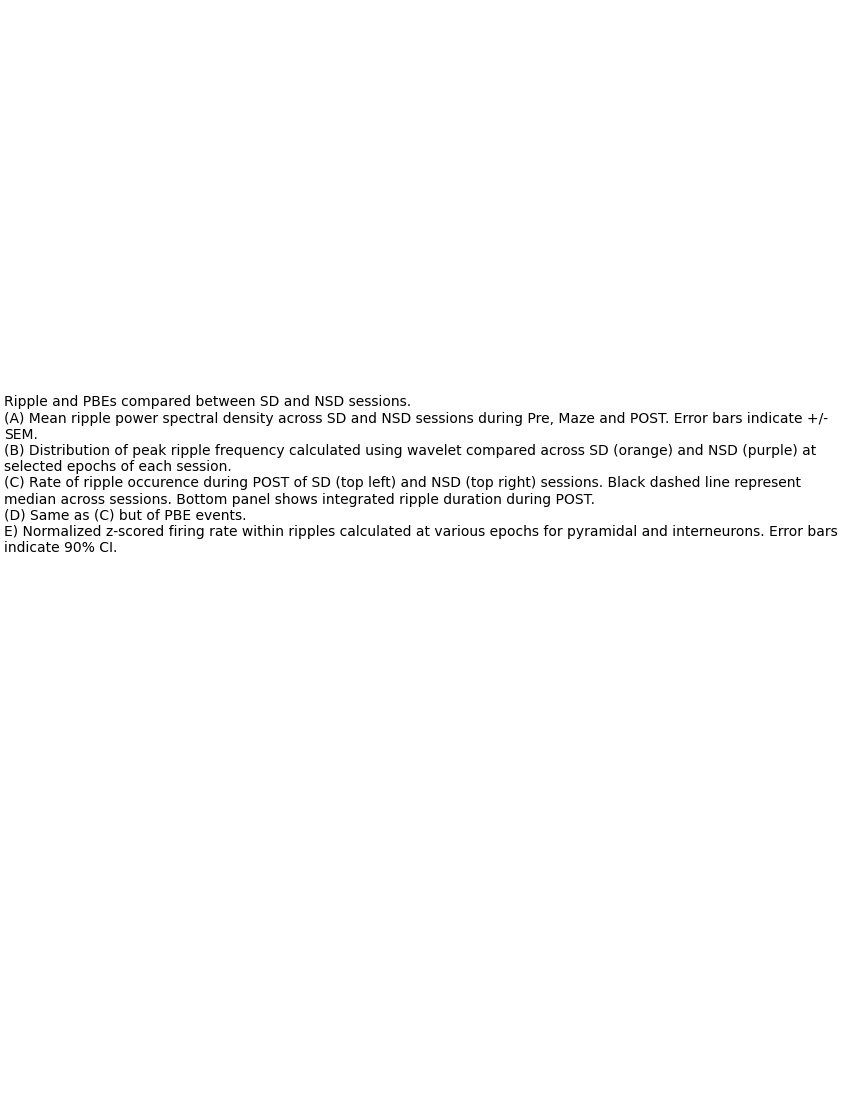

In [72]:
fig.savefig(filename,caption=caption)